In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header=None, sep='\s+')
df.columns = [
    'CRIM', 
    'ZN', 
    'INDUS', 
    'CHAS',
    'NOX', 
    'RM', 
    'AGE', 
    'DIS', 
    'RAD',
    'TAX', 
    'PTRATIO', 
    'B', 
    'LSTAT', 
    'MEDV'
]

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


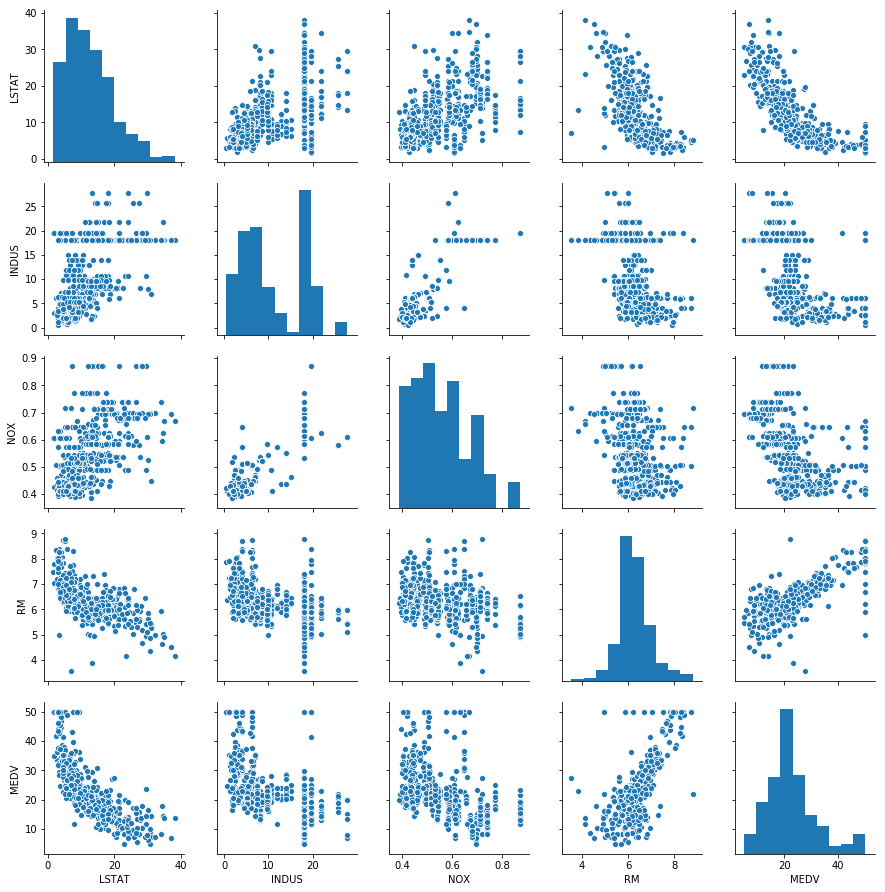

In [8]:
# Exploratory Data Analysis (EDA)

# scatter plots
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], height=2.5)
# sns.pairplot(df, height=2.5)

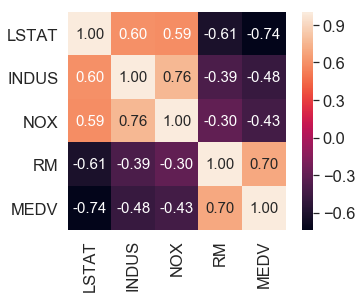

In [10]:
# correlations
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(
    cm,
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
    annot_kws={'size': 15},
    yticklabels=cols,
    xticklabels=cols
)

In [26]:
# changed from Adaline in ch2
class LinearRegressionGD:
    def __init__(self, eta=0.001, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter
    
    def fit(self, X, y):
        n_rows, n_factors = X.shape
        self.weights = np.zeros(n_factors + 1)
        self.costs = [] # keep track of cost per iter
        
        for i in range(self.n_iter):
            output = self.net_input(X) # all_predictions
            errors = y - output # an array of all prediction vs target results
            # instead of looping through each row, update weight with result of all rows
            self.weights[1:] += self.eta * X.T.dot(errors) 
            self.weights[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2.0 # cost fuction: sum of square means / 2; note: I believe the divison by 2 is not a must, it just allows the differentiation function to not carry any multiple
            self.costs.append(cost)
        return self
    
    # returns a float value
    def net_input(self, X):
        return np.dot(X, self.weights[1:]) + self.weights[0] # dot product plus constant
    
    # for predicting a test set
    def predict(self, X):
        return self.net_input(X)

In [27]:
X = df[['RM']].values # need to be a matrix
y = df[['MEDV']].values

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)[:,0]

lr = LinearRegressionGD()
lr.fit(X_std, y_std)


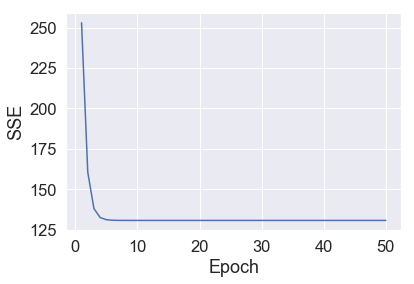

In [28]:
plt.plot(range(1, lr.n_iter+1), lr.costs)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [29]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return None

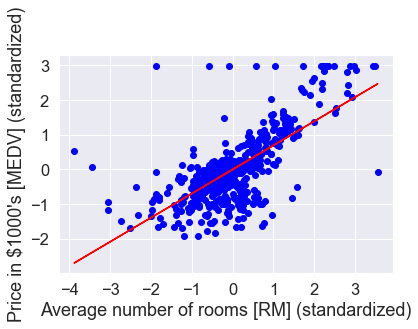

In [41]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots()
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [48]:
print('Slope: %.3f' % lr.weights[1])
print('Intercept: %.3f' % lr.weights[0])

Slope: 0.695
Intercept: -0.000


In [33]:
# get original value
num_rooms_std = sc_x.transform([[5.0]])
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


Text(0,0.5,"Price in $1000's [MEDV]")

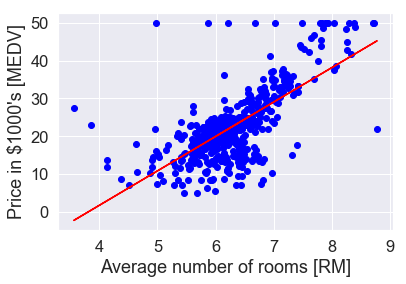

In [46]:
# plot of original value
plt.scatter(X, y, c='blue')
plt.plot(X, sc_y.inverse_transform(lr.predict(X_std)), color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')

Slope: 9.102
Intercept: -34.671


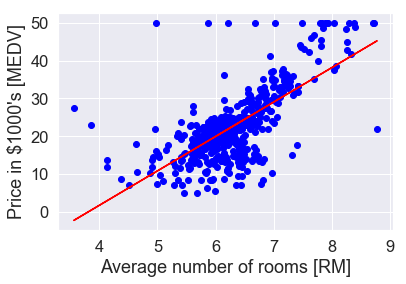

In [53]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)

lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

In [61]:
# Fitting with outlier-detection - RANdom SAmple Consensus (RANSAC)

from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100,
    min_samples=50,
    residual_metric=lambda x: np.sum(np.abs(x), axis=1),
    residual_threshold=5.0, # only allow samples to be included in the inlier set if their vertical distance to the fitted line is within 5 distance units
    random_state=0
)
ransac.fit(X, y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ransac.py:288: DeprecationWarning: 'residual_metric' was deprecated in version 0.18 and will be removed in version 0.20. Use 'loss' instead.
  DeprecationWarning)


RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_metric=<function <lambda> at 0x1a203b3ae8>,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

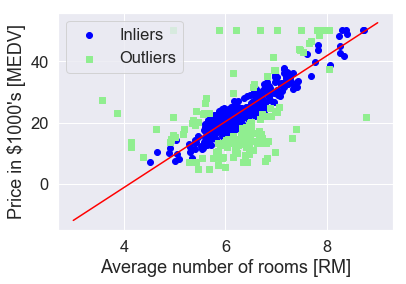

In [70]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis]) # ransac.predict expets matrix, i.e. [[3],[4],[5]...[9]]
plt.scatter(X[inlier_mask], y[inlier_mask], c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [71]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


In [ ]:
# Evaluating performance of linear regression model 